In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pyBigWig as bw

+
chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chrX
chrY
chrM
-
chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chrX
chrY
chrM
+
chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chrX
chrY
chrM
-
chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chrX
chrY
chrM


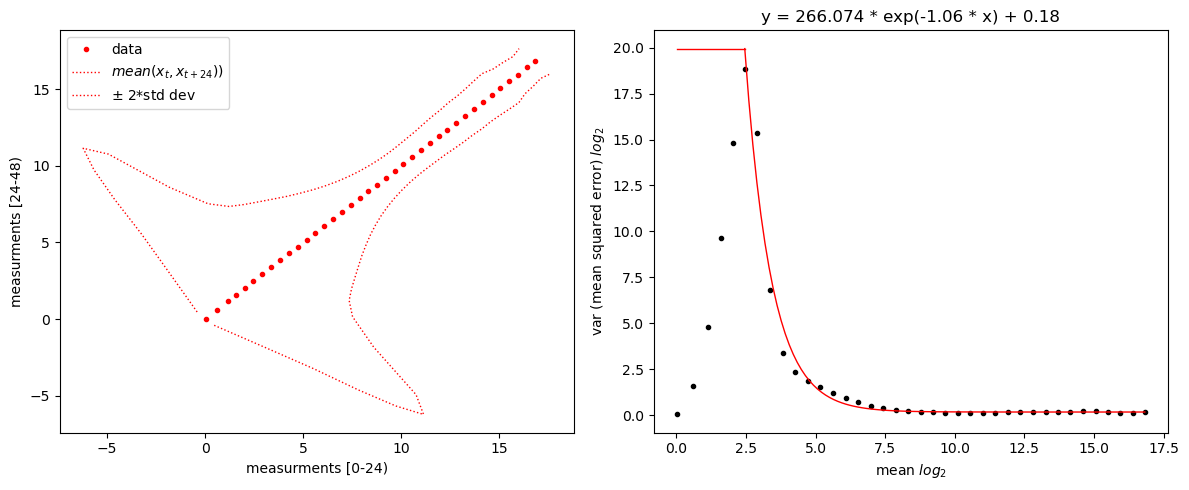

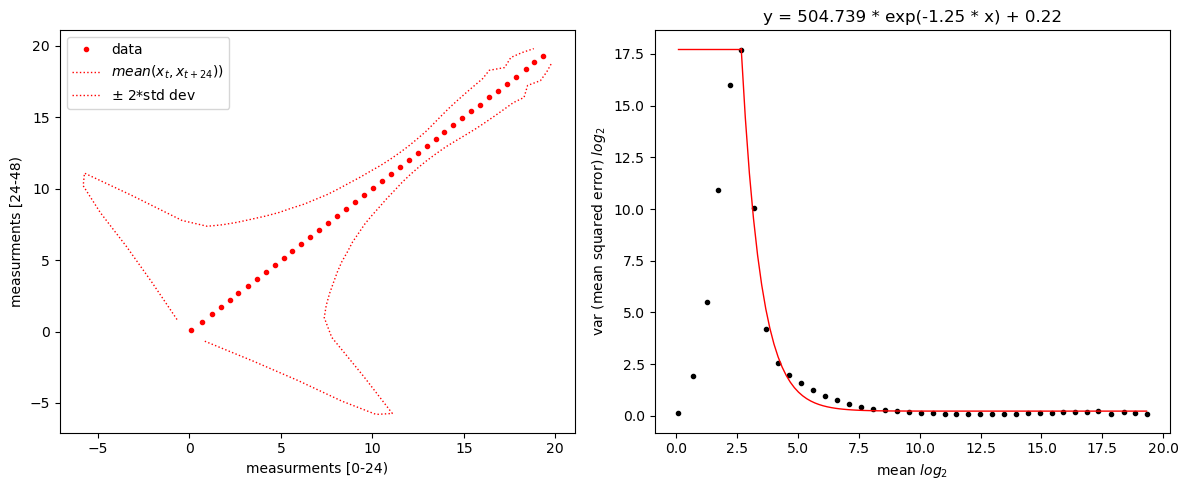

In [11]:
Strand = ['+', '-']
strand_dict = {'forward':'+',
                'reverse':'-',
                '+':'forward',
                '-':'reverse'}
CHR = [f'chr{c+1}' for c in range(0,19)] + ['chrX','chrY','chrM']
T = np.arange(0,48,4)
Samples = [f'CT{t:02d}' for t in T] 
bw_folder = '../results/binned_norm_coverage'

for bin_size in [1000,10000]:

    # load tables
    df = pd.DataFrame(columns=['start','end'])
    for strand in Strand:
        print(strand)
        for chr in CHR:
            print(chr)
            df_chr_strand = pd.DataFrame(columns=['start','end'])
            for t in T:
                sample = f'CT{t:02d}'
                fin = f"{bw_folder}/{sample}/NormCoverage_3p_{strand_dict[strand]}_bin{bin_size}bp.bw"
                f = bw.open(fin)
                df_t = pd.DataFrame(f.intervals(chr),columns=['start','end',sample])
                df_chr_strand = pd.merge(df_chr_strand,df_t,how='outer',on=['start','end'])
        
            df = pd.concat([df,df_chr_strand],axis=0)
    
    # remove chr start end strand
    df.drop(columns=['start','end'],inplace=True)

    # remove rows with more than 50% of nan values
    df.dropna(thresh=len(T)//2,inplace=True)

    df.fillna(0,inplace=True)
    df = df.apply(lambda x: np.log2(x+1),axis=1)

    # separate mesurments at time [0-24) and [24-48)
    x = df.loc[:,[f"CT{t:02d}" for t in np.arange(0 ,24,4)]].values.flatten()
    y = df.loc[:,[f"CT{t:02d}" for t in np.arange(24,48,4)]].values.flatten()
    #x = df.loc[:,[f"{t}{s}" for t in np.arange(0 ,24,4) for s in ['+', '-']]].values.flatten()
    #y = df.loc[:,[f"{t}{s}" for t in np.arange(24,48,4) for s in ['+', '-']]].values.flatten()
    df_err = pd.DataFrame({'x':x,'y':y})

    # estimate error as the difference between the two measurements
    n_bins = 50
    df_err['err'] = (df_err.x - df_err.y)**2
    df_err['m'] = (df_err.x + df_err.y)/2
    df_err['m_bin'] = pd.cut(df_err.m,n_bins)
    df_err['n'] = 1
    df_err = df_err.groupby(['m_bin'],observed=False).agg({'x':'mean','y':'mean','m':'mean','err':'mean','n':'sum'}).reset_index()
    # remove nan rows
    df_err = df_err.loc[~df_err.isna().any(axis=1),:]
    # remove bins with less than 10 measurements
    df_err = df_err.loc[df_err.n > 10,:]
    df_err.reset_index(drop=True, inplace=True)
    idx_err_max = np.argmax(df_err['err'].values)

    # exponential fit
    def func(x, a, lam, c):
        return a * np.exp(-lam * x) + c

    popt, pcov = curve_fit(func, df_err.loc[idx_err_max:,'m'].values, df_err.loc[idx_err_max:,'err'].values, p0=[100, 1, 0.1],maxfev=10000)
    err_max = func(df_err.at[idx_err_max,'m'], *popt)

    # plot
    fig, axes = plt.subplots(1,2,figsize=(12,5))

    ax = axes[0]
    #ax.scatter(x,y,s=1,c='k',alpha=.2,rasterized=True)
    ax.plot(df_err.m,df_err.m,'r.',lw=2)
    ax.plot(df_err.m - 2*np.sqrt(df_err['err']),df_err.m + 2*np.sqrt(df_err['err']),'r:',lw=1)
    ax.plot(df_err.m + 2*np.sqrt(df_err['err']),df_err.m - 2*np.sqrt(df_err['err']),'r:',lw=1)
    ax.set_xlabel('measurments [0-24)')
    ax.set_ylabel('measurments [24-48)')
    ax.legend(['data','$mean(x_t,x_{t+24})$)',r'$\pm$ 2*std dev'])

    ax = axes[1]
    ax.plot(df_err['m'],df_err['err'],'k.',lw=1)
    _x = np.linspace(df_err.at[idx_err_max,'m'],df_err.loc[:,'m'].values[-1],100)
    ax.plot(_x, func(_x, *popt), 'r-',lw=1)
    ax.plot(df_err.loc[[0,idx_err_max],'m'].values,[err_max,err_max],'r-',lw=1)

    ax.title.set_text(f"y = {popt[0]:.3f} * exp(-{popt[1]:.2f} * x) + {popt[2]:.2f}")
    ax.set_xlabel(r'mean $log_2$')
    ax.set_ylabel(r'var (mean squared error) $log_2$')


    fig.tight_layout()


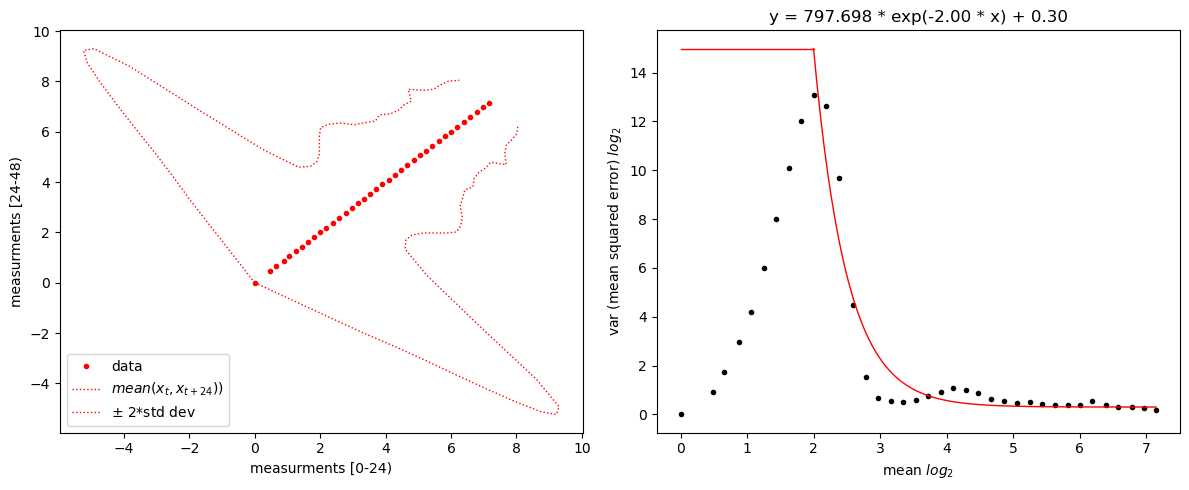

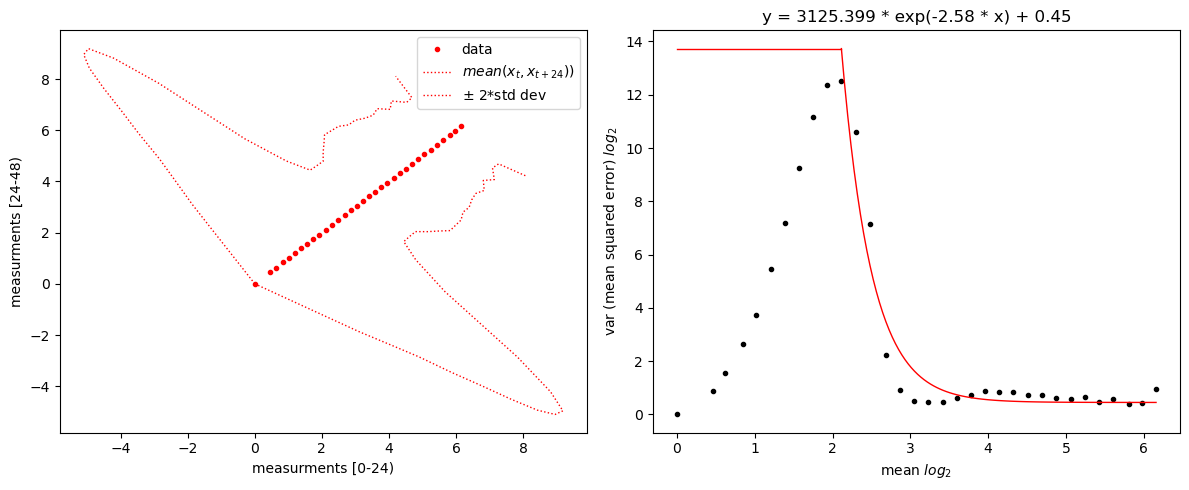

In [79]:
for bin_size in [1000, 10000]:
    CHR = [f'chr{c+1}' for c in range(0,19)] + ['chrX','chrY','chrM']
    Tables = [f'../results/binned_norm_coverage/NormCoverage_3p_bin{bin_size}bp_{c}.csv' for c in CHR]

    c = 'chr19'
    Tables = [f'../results/binned_norm_coverage/NormCoverage_3p_bin{bin_size}bp_{c}.csv']

    # load tables
    df = pd.DataFrame()
    for fin in Tables:
        df_t = pd.read_csv(fin,index_col=0,sep='\t')
        # remove rows with less that 50% of nans
        #df_t = df_t.loc[df_t.isna().sum(axis=1) < df_t.shape[1]/2,:]
        df = pd.concat([df,df_t],axis=0)
    df.fillna(0,inplace=True)
    df = df.apply(lambda x: np.log2(x+1),axis=1)

    # separate mesurments at time [0-24) and [24-48)
    x = df.loc[:,[f"CT{t:02d}{s}" for t in np.arange(0 ,24,4) for s in ['+', '-']]].values.flatten()
    y = df.loc[:,[f"CT{t:02d}{s}" for t in np.arange(24,48,4) for s in ['+', '-']]].values.flatten()
    #x = df.loc[:,[f"{t}{s}" for t in np.arange(0 ,24,4) for s in ['+', '-']]].values.flatten()
    #y = df.loc[:,[f"{t}{s}" for t in np.arange(24,48,4) for s in ['+', '-']]].values.flatten()
    df_err = pd.DataFrame({'x':x,'y':y})

    # estimate error as the difference between the two measurements
    n_bins = 50
    df_err['err'] = (df_err.x - df_err.y)**2
    df_err['m'] = (df_err.x + df_err.y)/2
    df_err['m_bin'] = pd.cut(df_err.m,n_bins)
    df_err['n'] = 1
    df_err = df_err.groupby(['m_bin'],observed=True).agg({'x':'mean','y':'mean','m':'mean','err':'mean','n':'sum'}).reset_index()
    # remove nan rows
    df_err = df_err.loc[~df_err.isna().any(axis=1),:]
    # remove bins with less than 10 measurements
    df_err = df_err.loc[df_err.n > 10,:]
    df_err.reset_index(drop=True, inplace=True)
    idx_err_max = np.argmax(df_err['err'].values)

    # exponential fit
    def func(x, a, lam, c):
        return a * np.exp(-lam * x) + c

    popt, pcov = curve_fit(func, df_err.loc[idx_err_max:,'m'].values, df_err.loc[idx_err_max:,'err'].values, p0=[100, 1, 0.1],maxfev=10000)
    err_max = func(df_err.at[idx_err_max,'m'], *popt)

    # plot
    fig, axes = plt.subplots(1,2,figsize=(12,5))

    ax = axes[0]
    #ax.scatter(x,y,s=1,c='k',alpha=.2,rasterized=True)
    ax.plot(df_err.m,df_err.m,'r.',lw=2)
    ax.plot(df_err.m - 2*np.sqrt(df_err['err']),df_err.m + 2*np.sqrt(df_err['err']),'r:',lw=1)
    ax.plot(df_err.m + 2*np.sqrt(df_err['err']),df_err.m - 2*np.sqrt(df_err['err']),'r:',lw=1)
    ax.set_xlabel('measurments [0-24)')
    ax.set_ylabel('measurments [24-48)')
    ax.legend(['data','$mean(x_t,x_{t+24})$)',r'$\pm$ 2*std dev'])

    ax = axes[1]
    ax.plot(df_err['m'],df_err['err'],'k.',lw=1)
    _x = np.linspace(df_err.at[idx_err_max,'m'],df_err.loc[:,'m'].values[-1],100)
    ax.plot(_x, func(_x, *popt), 'r-',lw=1)
    ax.plot(df_err.loc[[0,idx_err_max],'m'].values,[err_max,err_max],'r-',lw=1)

    ax.title.set_text(f"y = {popt[0]:.3f} * exp(-{popt[1]:.2f} * x) + {popt[2]:.2f}")
    ax.set_xlabel(r'mean $log_2$')
    ax.set_ylabel(r'var (mean squared error) $log_2$')


    fig.tight_layout()
